In [69]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join


class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [70]:
import random


training_images_filepath = r'C:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\input\train-images-idx3-ubyte\train-images-idx3-ubyte'
training_labels_filepath = r'C:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\input\train-labels-idx1-ubyte\train-labels-idx1-ubyte'
test_images_filepath = r'C:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\input\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte'
test_labels_filepath = r'C:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\input\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()
X_train = np.array(X_train).reshape(60000, 784)
X_test = np.array(X_test).reshape(10000, 784)
X_train = ((X_train / 255.) - .5) * 2
X_test = ((X_test / 255.) - .5) * 2

In [71]:
y_train = np.array(y_train)
y_test = np.array(y_test)

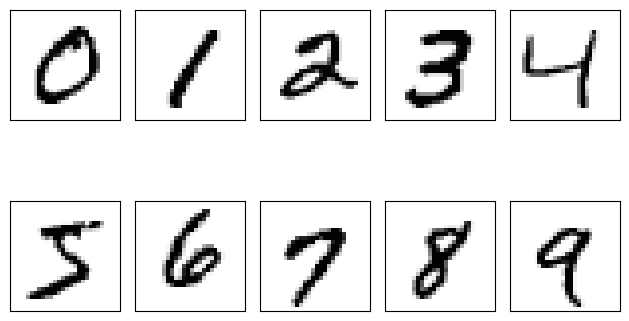

In [72]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [73]:
np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [2]:
import numpy as np


mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [3]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

In [ ]:
import sys
import numpy as np


class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        self.n_hidden = n_hidden # количество скрытых элементов
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.random = np.random.RandomState(seed)

    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1 # по строке значение, по столбцу индекс

        return onehot.T # строки - индексы, столбцы - названия классов
    
    def _sigmoid(self, z):
        # просто функция сигмоиды, но на z есть ограничения и если оно будет за них выходить, то его значение будет приравниваться к границам. Иначе могут быть ошибки.
        # по сути возвращает вероятность принадлежности классу
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """
        X - матрица образцов и их признаков: N x M;
        w_h - матрица весов скрытая: M x H;
        w_out - матрица весов выхода: H x C;
        b_h - смещение скрытой: H x 1; 
        b_out - смещение выхода: C x 1;
        """
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 * (np.sum(self.w_h ** 2) + np.sum(self.w_out ** 2))) # L2-регулирующий коэффициент
        # y_enc - one-hot кодированные истинные метки, логарифм используем для более быстрого исправления ошибок. 
        # в силу логарифма значения в матрице получаются неотрицательными
        term1 = -y_enc * np.log(output) # возрастает при плохих ответах
        term2 = (1 - y_enc) * np.log(1 - output) # убывает при плохих ответах
        # кросс-энтропийная потеря
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        # там чем больше z, тем больше вероятность принадлежности к классу
        y_pred = np.argmax(z_out, axis=1)
        
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        # вектор-смещение и матрица весов скрытого слоя
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        # аналогично для выходного слоя
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            # мини-пакетный спуск
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                delta_out = a_out - y_train_enc[batch_idx]

                sigmoid_derivative_h = a_h * (1. - a_h)

                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)

                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h # смещение без регуляризации

                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out # смещение без регуляризации
                
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])
            
            sys.stderr.write("\r%0*d/%d | Издержки: %.2f | Правильность при обучении/проверке: %.2f%%/%.2f%%" % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self

In [ ]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=50, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)

nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

50/50 | Издержки: 12211.48 | Правильность при обучении/проверке: 97.14%/97.14%

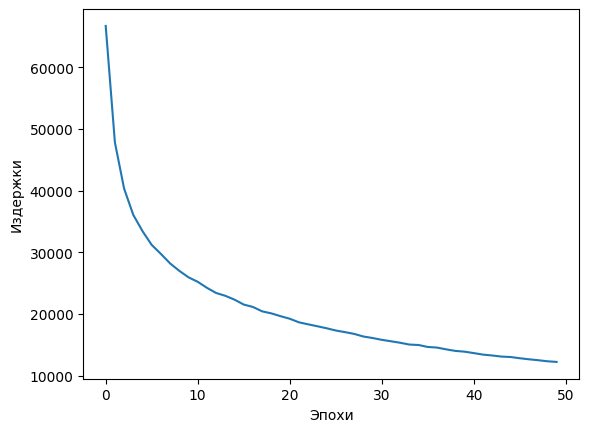

In [14]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Издержки')
plt.xlabel('Эпохи')
plt.show()

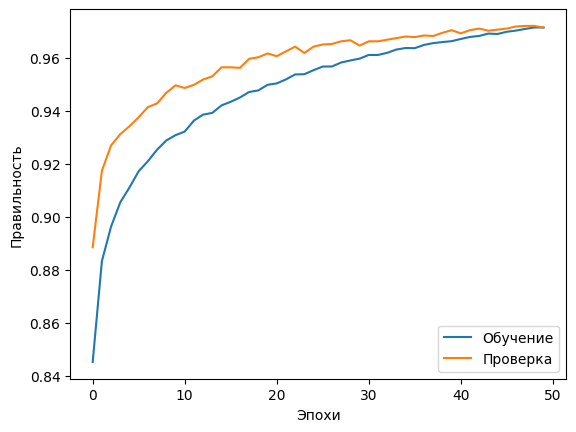

In [15]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Обучение')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Проверка')
plt.ylabel('Правильность')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()

In [16]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)).astype(float) / X_test.shape[0]
print('Правильность на тестовом наборе: %.2f%%' % (acc*100))

Правильность на тестовом наборе: 96.32%
